In [11]:
# Lo unico que no sabes bien es si compute ROC curve con val tambien,
# porque recuerda que cuando la calculas Xtrain ya es menor
# Tambien si p value calcularlo con todo el xTrain o con Xval??????

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

In [12]:
df = pd.read_csv("dataCOMP0050Coursework1.csv")
# Quitaste mort acc porque tiene valores con NaN
inputs = df.drop(["issue_d","purpose","application_type","mort_acc","home_ownership","verification_status"],axis = "columns")
# Default costumers
print(len(inputs))
inputs = inputs.dropna() #Drops all NaN values
print(len(inputs)) # solo quito como 500 filas
target = inputs["charged_off"]
inputs = inputs.drop("charged_off",axis = "columns")
inputs = inputs.drop(["earliest_cr_line","pub_rec","revol_util","pub_rec_bankruptcies","log_revol_bal"],axis = "columns")
inputs.head()

8929
8474


,loan_amnt,term,installment,emp_length,dti,open_acc,total_acc,log_annual_inc,fico_score
0,5675,36,189.56,2.0,15.55,7,15,4.698979,697.0
1,7000,36,242.63,1.0,6.78,3,5,4.301052,717.0
2,3500,36,116.24,10.0,10.65,16,35,4.681250,742.0
3,10000,36,316.47,10.0,21.74,7,22,4.875067,707.0
4,1500,36,46.31,2.0,12.17,8,13,4.812920,712.0


In [15]:
#Checa que cambia si usas standardscalar() aqui como en chyperparam
XTrain, XTest, yTrain, yTest = train_test_split(inputs, target, test_size=0.30, random_state=3)
print(len(XTrain),len(XTest),len(yTrain),len(yTest))
print(np.mean(XTrain))
yTest = yTest.to_numpy() # Solo se corre una veeez
yTrain= yTrain.to_numpy() # Solo se corre una veeez

5931 2543 5931 2543
loan_amnt         8647.711179
term                40.410723
installment        264.414144
emp_length           5.307031
dti                 14.096198
open_acc             9.880121
total_acc           22.157478
log_annual_inc       4.766243
fico_score         710.625948
dtype: float64


In [17]:
# Count defaults
zeros = 0
ones = 0
for r in range(len(yTest)):
    if yTest[r] == 0:
        zeros = zeros +1
    else:
        ones = ones +1
print(zeros, ones)

# No skill

ns = ones/(zeros+ones)
print(ns)
NS = ns*np.ones(10)

2183 360
0.1415650806134487


In [18]:
XVal = XTrain[:1695]
yVal = yTrain[:1695]
XTrain = XTrain[1695:5931]
yTrain = yTrain[1695:5931]
print(len(XTrain),len(XVal),len(yTrain),len(yVal))
# Nos queda 50% train, 20% val y 30% Test
#yVal = yVal.to_numpy()

4236 1695 4236 1695


In [19]:
# Count defaults
zeros = 0
ones = 0
for r in range(len(yVal)):
    if yVal[r] == 0:
        zeros = zeros +1
    else:
        ones = ones +1
print(zeros, ones)

# No skill

ns = ones/(zeros+ones)
print(ns)
NS = ns*np.ones(10)

1470 225
0.13274336283185842


In [63]:
model = LogisticRegression(solver='liblinear', C=.0215, penalty="l2")
model.fit(XTrain, yTrain)

LogisticRegression(C=0.0215, solver='liblinear')

In [64]:
yPredicted = model.predict(XVal)
s = model.predict_proba(XVal)

In [65]:
# Optimal Threshold for Precision-Recall Curve [Recall = sensitivity]
precision = np.zeros(1000)
recall = np.zeros(1000)
sens = 0
F_prov = .0000001
F = 0
for j in range(1000):
    cont = np.zeros((2,2))
    p = (j+1)/1000
    for i in range(len(s)):
        if s[i][1] > p:
            pred = 1
            if pred == yVal[i]:
                cont[1][1] = cont[1][1] +1
            else:
                cont[0][1] = cont[0][1] +1
        else:
            pred = 0
            if pred == yVal[i]:
                cont[0][0] = cont[0][0] +1
            else:
                cont[1][0] = cont[1][0] +1
    if cont[1][1] > 0 and cont[1][0] > 0 : # todos estos if son solo para checar que no divida entre 0
        sens = cont[1][1]/(cont[1][1]+cont[1][0])
        recall[j] = sens
    if cont[1][1] > 0 and cont[0][1] > 0 :
        precis = cont[1][1]/(cont[1][1]+cont[0][1])
        precision[j] = precis
    if precis > 0 and sens > 0:
        F_prov = (2*precis*sens)/(precis+sens) #(2 * Precision * Recall) / (Precision + Recall)
    if F_prov > F:
        F = F_prov
        pval = p
print(F,pval) 

0.32978723404255317 0.204


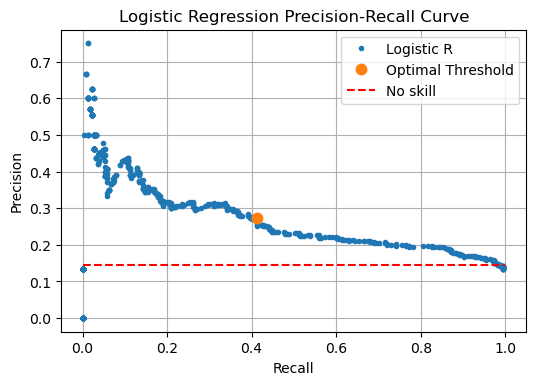

In [66]:
plot1 = plt.figure(1,figsize=(6,4), dpi=100)
plt.plot(recall,precision,".", label= "Logistic R")
plt.plot(recall[int((pval*1000)-1)],precision[int((pval*1000)-1)],".",markersize=15, label= "Optimal Threshold")
plt.plot(np.linspace(0,1,10),NS,"--r", label= "No skill")
plt.title('Logistic Regression Precision-Recall Curve')
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.grid()
plt.legend()
#plt.savefig('Precision-Recall-LR.png')

In [67]:
prob = model.predict_proba(XTest)

In [68]:
# Te da la matrix con el pval
cont = np.zeros((2,2))
for i in range(len(prob)):
    if prob[i][1] > pval:
        pred = 1
        if pred == yTest[i]:
            cont[1][1] = cont[1][1] +1
        else:
            cont[0][1] = cont[0][1] +1
    else:
        pred = 0
        if pred == yTest[i]:
            cont[0][0] = cont[0][0] +1
        else:
            cont[1][0] = cont[1][0] +1       
print(cont)

[[1812.  371.]
 [ 197.  163.]]


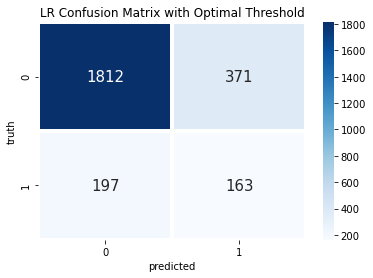

In [69]:
import seaborn as sn
plt.figure(figsize=(6,4))
sn.heatmap(cont,annot=True,linewidths=3,cmap='Blues', fmt='g',annot_kws={"size": 15}) # checa que esta el cont aqui
plt.title('LR Confusion Matrix with Optimal Threshold')
plt.xlabel("predicted")
plt.ylabel("truth")
plt.savefig('CM-LR-optimal.png')

In [70]:
yPredicted = model.predict(XTest)
cm = confusion_matrix(yTest,yPredicted)
print(cm)

[[2176    7]
 [ 347   13]]


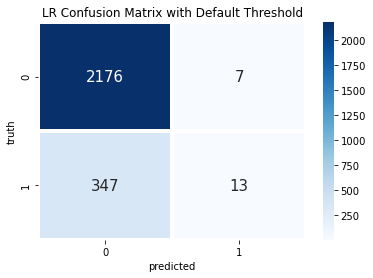

In [71]:
plt.figure(figsize=(6,4))
sn.heatmap(cm,annot=True,linewidths=3,cmap='Blues', fmt='g',annot_kws={"size": 15}) # checa que esta el cont aqui
plt.title('LR Confusion Matrix with Default Threshold')
plt.xlabel("predicted")
plt.ylabel("truth")
plt.savefig('CM-LR.png')

Area Under Curve Logistic Train =  0.6873808203259119
Area Under Curve Logistic Test =  0.7271784496360767
[[2176    7]
 [ 347   13]]


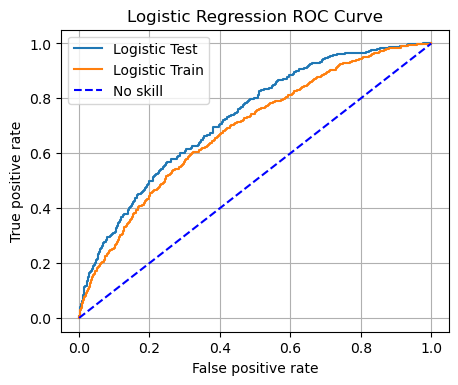

In [72]:
pTrain = model.predict_proba(XTrain)
pTrain = pTrain[:,1] #Because the above gives two columns, probability of 0 and probability of 1, we only want the later

pTest = model.predict_proba(XTest)
pTest = pTest[:,1]

#AUC values [Cuando sale .5 es que todas tus predicciones estan mal, lo puedes simular metiendo puros ceros a pTrain o pTest]
AUCTrain = roc_auc_score(yTrain, pTrain)    
AUCTest = roc_auc_score(yTest, pTest)
print("Area Under Curve Logistic Train = ",AUCTrain) 
print("Area Under Curve Logistic Test = ",AUCTest)

yPredicted = model.predict(XTest)
cm = confusion_matrix(yTest,yPredicted)
print(cm)
# Calculate ROC Curves [False positives agains True positives]
FPTrain, TPTrain, _ = roc_curve(yTrain, pTrain)
    
FPTest, TPTest, _ = roc_curve(yTest, pTest)

plot0 = plt.figure(0,figsize=(5,4), dpi=100)
plt.title('Logistic Regression ROC Curve')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.plot(FPTest, TPTest, label='Logistic Test')
plt.plot(FPTrain, TPTrain, label='Logistic Train')
plt.plot([0,1],[0,1],"--b",label='No skill')
plt.legend() #Show legend
plt.grid()
plt.savefig('ROC-LR.png')

In [73]:
model = RandomForestClassifier(max_features=.5, n_estimators = 100, max_depth = 5) #Como que funciona mejor default
model.fit(XTrain,yTrain)
model.score(XVal,yVal)

0.8660766961651918

In [74]:
m = model.predict_proba(XVal)

In [75]:
print(AUCTest)
print(AUCTrain)

0.7271784496360767
0.6873808203259119


In [77]:
# Optimal Threshold for Precision-Recall Curve [Recall = sensitivity]
precision = np.zeros(1000)
recall = np.zeros(1000)
sens = 0
F = 0
F_prov = 0
for j in range(1000):
    cont = np.zeros((2,2))
    p = (j+1)/1000
    for i in range(len(m)):
        if m[i][1] > p:
            pred = 1
            if pred == yVal[i]:
                cont[1][1] = cont[1][1] +1
            else:
                cont[0][1] = cont[0][1] +1
        else:
            pred = 0
            if pred == yVal[i]:
                cont[0][0] = cont[0][0] +1
            else:
                cont[1][0] = cont[1][0] +1
    if cont[1][1] > 0 and cont[1][0] > 0 : # todos estos if son solo para checar que no divida entre 0
        sens = cont[1][1]/(cont[1][1]+cont[1][0])
        recall[j]= sens
    if cont[1][1] > 0 and cont[0][1] > 0 :
        precis = cont[1][1]/(cont[1][1]+cont[0][1])
        precision[j]= precis
    if precis > 0 and sens > 0:
        F_prov = (2*precis*sens)/(precis+sens) #(2 * Precision * Recall) / (Precision + Recall)
    if F_prov > F:
        F = F_prov
        pval = p
print(F,pval) 

0.3269230769230769 0.158


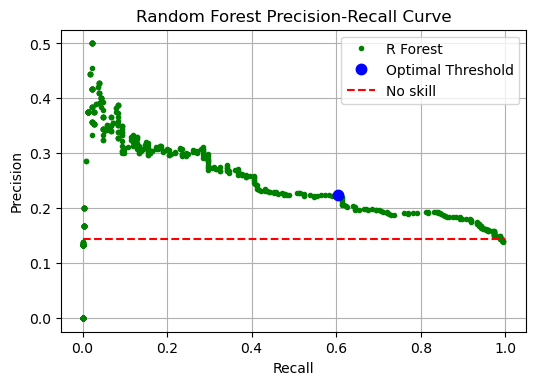

In [78]:
plot2 = plt.figure(2,figsize=(6,4), dpi=100)

plt.plot(recall,precision,"g.", label= "R Forest")
plt.plot(recall[int((pval*1000)-1)],precision[int((pval*1000)-1)],"b.", markersize=15, label= "Optimal Threshold")
plt.plot(np.linspace(0,1,10),NS,"--r", label= "No skill")
plt.title('Random Forest Precision-Recall Curve')
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.grid()
plt.legend()
plt.savefig('Precision-Recall-RF.png')

In [79]:
prob = model.predict_proba(XTest)
# Te da la matrix con el pval
cont = np.zeros((2,2))
for i in range(len(prob)):
    if prob[i][1] > pval:
        pred = 1
        if pred == yTest[i]:
            cont[1][1] = cont[1][1] +1
        else:
            cont[0][1] = cont[0][1] +1
    else:
        pred = 0
        if pred == yTest[i]:
            cont[0][0] = cont[0][0] +1
        else:
            cont[1][0] = cont[1][0] +1       
print(cont)

[[1430.  753.]
 [ 121.  239.]]


In [80]:
yPredicted = model.predict(XTest)
cm = confusion_matrix(yTest,yPredicted)

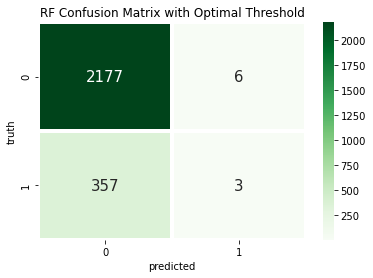

In [81]:
import seaborn as sn
plt.figure(figsize=(6,4))
sn.heatmap(cm,annot=True,linewidths=3,cmap='Greens', fmt='g',annot_kws={"size": 15}) # checa que esta el cont aqui
plt.title('RF Confusion Matrix with Optimal Threshold')
plt.xlabel("predicted")
plt.ylabel("truth")
plt.savefig('CM-RF-optimal.png')

In [82]:
print(len(XTest))

2543


Area Under Curve Logistic Train =  0.7838285397353616
Area Under Curve Logistic Test =  0.7244210312006922
[[2177    6]
 [ 357    3]]


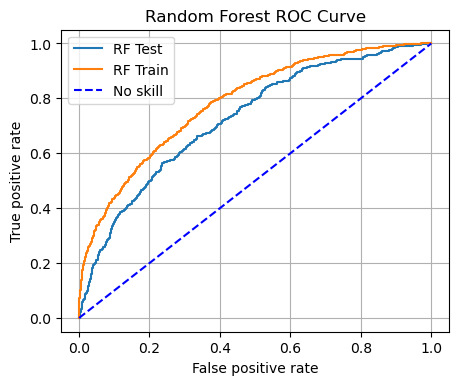

In [83]:
pTrain = model.predict_proba(XTrain)
pTrain = pTrain[:,1] #Because the above gives two columns, probability of 0 and probability of 1, we only want the later

pTest = model.predict_proba(XTest)
pTest = pTest[:,1]

#AUC values [Cuando sale .5 es que todas tus predicciones estan mal, lo puedes simular metiendo puros ceros a pTrain o pTest]
AUCTrain = roc_auc_score(yTrain, pTrain)    
AUCTest = roc_auc_score(yTest, pTest)
print("Area Under Curve Logistic Train = ",AUCTrain) 
print("Area Under Curve Logistic Test = ",AUCTest)

yPredicted = model.predict(XTest)
cm = confusion_matrix(yTest,yPredicted)
print(cm)
# Calculate ROC Curves [False positives agains True positives]
FPTrain, TPTrain, _ = roc_curve(yTrain, pTrain)
    
FPTest, TPTest, _ = roc_curve(yTest, pTest)

plot0 = plt.figure(0,figsize=(5,4), dpi=100)
plt.title('Random Forest ROC Curve')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.plot(FPTest, TPTest, label='RF Test')
plt.plot(FPTrain, TPTrain, label='RF Train')

plt.plot([0,1],[0,1],"--b",label='No skill')
plt.legend() #Show legend
plt.grid()
plt.savefig('ROC-RF.png')

In [87]:
print(AUCTrain)

0.7838285397353616


In [85]:
yPredicted = model.predict(XTest)
cm = confusion_matrix(yTest,yPredicted)
print(cm)

[[2177    6]
 [ 357    3]]
